**1.** Run the following cells to setup the environment

In [8]:
import requests, pandas as pd, json, copy
from IPython.display import JSON, Image
from requests.auth import HTTPBasicAuth

In [9]:
URL = 'http://mira.isi.edu:8000'
auth = HTTPBasicAuth('mint', 'm290sjafds8!')

**2.** Load a dataset that we want to model, and show the content of the dataset.

The dataset is supposed to be a [relational table](https://www.ibm.com/support/knowledgecenter/SSWU4L/Data/imc_Data/Data_q_a_watson_assistant/Relational_Tables371.html). If the data format is CSV, the first row is the header.

In [10]:
df = pd.read_csv('./examples/ethiopia_dashboard.csv', header=0)
df.head(5)

,Country Name,Unnamed: 1,"Population, total","Life expectancy at birth, total (years)","GNI per capita, Atlas method (current US$)",GDP (current US$),CO2 emissions (metric tons per capita)
0,Ethiopia,1960,22151278.0,38.419,NaN,NaN,0.015892
1,Ethiopia,1961,22671191.0,39.082,NaN,NaN,0.015042
2,Ethiopia,1962,23221389.0,39.711,NaN,NaN,0.017055
3,Ethiopia,1963,23798430.0,40.290,NaN,NaN,0.017720
4,Ethiopia,1964,24397022.0,40.810,NaN,NaN,0.016684


**3.** To send the table to the API for annotation, we need to convert the original table into a JSON format below:
```json
{
    "ontologies": ["http://wikiba.se/ontology#"],
    "source": [
        {"name": "<column name>", "values": ["<value of the column in first row>", "<value of the column in second row>", "..."]
    ]
}
```
and send it in the body of a `POST` request to `/v1/annotate`

In [16]:
payload = {
    "ontologies": ["http://wikiba.se/ontology#"],
    "source": [
        {"name": "" if c.startswith("Unnamed:") else c, "values": df[c].tolist()}
        for c in df.columns
    ]
}
resp = requests.post(URL + "/v1/annotate", json=payload, auth=auth)
assert resp.status_code == 200

**4.** The JSON response that the server returns are in the following format:
```json
{
    "sm": {
        "<ont_class_id>": {
            "iri": "<uri of the ontology class>",
            "properties": [
                ["<ontology predicate 1>", "<column_index>"], 
                ["<ontology predicate 2>", "<column_index>"]
            ],
            "links": [
                ["<ontology predicate 1>", "<ont_class_id>"]
            ]
        }
    },
    "prefixes": {
        "<prefix>": "<url>"
    }
}
```

In [17]:
JSON(resp.json(), indent=4)

<IPython.core.display.JSON object>

Run the following cell to make the previous response friendly

In [18]:
data = copy.deepcopy(resp.json())
data['columns'] = df.columns.tolist()

In [29]:
resp2 = requests.post(URL + "/v1/draw", json=data, auth=auth, stream=all)
assert resp2.status_code == 200

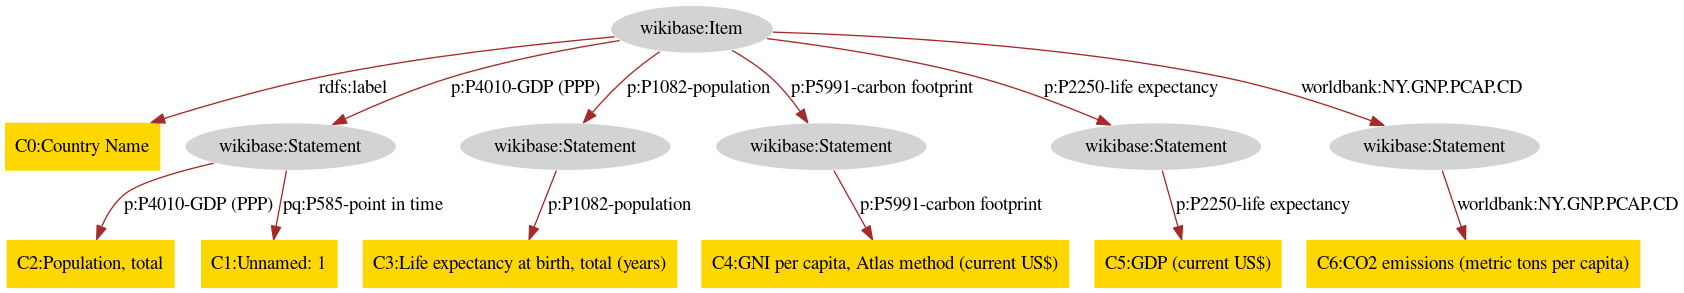

In [30]:
display(Image(resp2.content))

The semantic model above describes that the first column (`C0:Country Name`) contains labels of Wikidata entities. Column `C2:Population, total` contains GDPs of the country reported at a point in time (`C1: Unnamed: 1`). In Wikidata, properties' values of an entity are represented as statements (`wikibase:Statement`), which may have additional qualifiers such as who state the statements (e.g., provenance), etc. Beside the information about the population, we also have other properties such as life expectancy, GDP, etc.